<a href="https://colab.research.google.com/github/nparslow/disfluency_gen/blob/develop/docs/tutorials/nmt_with_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# refactored from:
#https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/nmt_with_attention.ipynb

import os
import sys
repoRoot = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(repoRoot, "src", "disfluency_generator"))

import tensorflow as tf
from machine_translator import load_data, create_dataset, print_examples, tf_lower_and_split_punct,\
    create_text_processor
from encoder import Encoder
from decoder import Decoder
from trainTranslator import TrainTranslator, BatchLogs
from maskedLoss import MaskedLoss

from translator import Translator
from trainTranslator import TrainTranslator

import pathlib


In [3]:
# load data
data_path = pathlib.Path("/home/nickp/Documents/tutorials/disfluency_generator/data")
verbose = 1
#------------------
data_filename = pathlib.Path(data_path, "spa-eng", "spa.txt")

targets, inputs = load_data(data_filename)

if verbose > 0:
    print(f"Last example of data:\n{inputs[-1]}\n{targets[-1]}")

dataset = create_dataset(inputs, targets, BATCH_SIZE=64)

if verbose > 0:
    print_examples(dataset)

# todo - check with corpus:
max_vocab_size = 5000

input_text_processor = create_text_processor(inputs, max_vocab_size)

if verbose > 0:
    # todo better checking:
    print("First 10 words of input vocab:")
    print(input_text_processor.get_vocabulary()[:10])

# note - we don't have to have the same output vocab size:
output_text_processor = create_text_processor(targets, max_vocab_size)

if verbose > 0:
    print("First 10 words of target vocab:")
    print(output_text_processor.get_vocabulary()[:10])

if verbose > 0:
    for example_input_batch, example_target_batch in dataset.take(1):
        print("Example input token sequences (indices):")
        example_tokens = input_text_processor(example_input_batch)
        print(example_tokens[:3, :10])


Last example of data:
Si quieres sonar como un hablante nativo, debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un músico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado.
If you want to sound like a native speaker, you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo.
tf.Tensor(
[b'Se fue a la tienda en bicicleta.'
 b'Me acordar\xc3\xa9 de ti para siempre.'
 b'\xc2\xbfDe qui\xc3\xa9n esperas obtener regalos de Navidad?'
 b'\xc2\xbfVes lo que quiero decir?' b'T\xc3\xba no eres japon\xc3\xa9s.'], shape=(5,), dtype=string)

tf.Tensor(
[b'She took her bike to the store.' b"I'll remember you forever."
 b'Who do you expect to receive Christmas presents from?'
 b'Do you see what I mean?' b'You are not Japanese.'], shape=(5,), dtype

Before getting into it define a few constants for the model:

In [4]:
embedding_dim = 256
units = 1024

Now that you're confident that the training step is working, build a fresh copy of the model to train from scratch:

### Train the model

While there's nothing wrong with writing your own custom training loop, implementing the `Model.train_step` method, as in the previous section, allows you to run `Model.fit` and avoid rewriting all that boiler-plate code. 

This tutorial only trains for a couple of epochs, so use a `callbacks.Callback` to collect the history of batch losses, for plotting:

In [5]:

batch_loss = BatchLogs('batch_loss')

In [6]:

train_translator = TrainTranslator(
    embedding_dim, units,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor)

# Configure the loss and optimizer
train_translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
)


In [ ]:
train_translator.fit(dataset, epochs=1,
                     callbacks=[batch_loss])

Text(0, 0.5, 'CE/token')

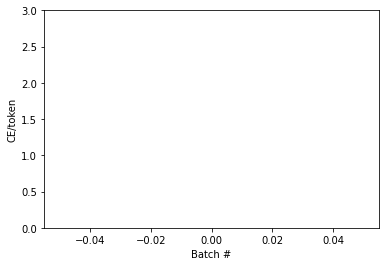

In [7]:
import matplotlib.pyplot as plt
plt.plot(batch_loss.logs)
plt.ylim([0, 3])
plt.xlabel('Batch #')
plt.ylabel('CE/token')

In [8]:
translator = Translator(
    encoder=train_translator.encoder,
    decoder=train_translator.decoder,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor,
)

In [9]:
tf.saved_model.save(translator, 'translator',
                    signatures={'serving_default': translator.tf_translate})


FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.



FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.


INFO:tensorflow:Assets written to: translator/assets


INFO:tensorflow:Assets written to: translator/assets


In [11]:
reloaded = tf.saved_model.load('translator')


In [14]:
# testing
three_input_text = tf.constant([
    # This is my life.
    'Esta es mi vida.',
    # Are they still home?
    '¿Todavía están en casa?',
    # Try to find out.'
    'Tratar de descubrir.',
])

result = reloaded.tf_translate(three_input_text)

#%%time
result = reloaded.tf_translate(three_input_text)

for tr in result['text']:
  print(tr.numpy().decode())

print()

club york stands rats collected nowhere shoulders criticize colds describe bowed environment working someday flush abuse rare photo tidy chinese department teresa watermelon restaurant growth plate dictionary beach nervous memory just purchase sisters direction whining square bark homeless city medication died filled pigs burning overcome puppy punctual button technique scraps
completed shoulder consideration interested growing separately fat pronounce apology economy rug cross exceptions showed marrying poverty airport spoiled neighborhood supper gang collection roll slightest reveal supplied card earthquake owns passengers betrayed fish refrigerator misled brakes consists seize several community cotton understand belt sympathy politician plays relative sailors ships slip champion
nurse causing dealing tattoo dice coast build sons breath computer spell husbands daily conservative tomorrow shaving arrest too saves time potatoes beef slightly facebook comfortable rose risk visited messa